In [1]:
import sim
import numpy as np
import sympy as sp

def connect(port):
# Establece la conexión a VREP
# port debe coincidir con el puerto de conexión en VREP
# retorna el número de cliente o -1 si no puede establecer conexión
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID

# Conectarse al servidor de VREP
# *** ejecutar cada vez que se reinicia la simulación ***
clientID = connect(19999)

returnCode,handle=sim.simxGetObjectHandle(clientID,'Dummy',sim.simx_opmode_blocking)
dummy = handle
# Identificar las Articulaciones
ret,joint1=sim.simxGetObjectHandle(clientID,'Art_1',sim.simx_opmode_blocking)
ret,joint2=sim.simxGetObjectHandle(clientID,'Art_2',sim.simx_opmode_blocking)

conectado a 19999


In [2]:
returnCode,pos=sim.simxGetObjectPosition(clientID, joint2, -1, sim.simx_opmode_blocking)
print(pos)
returnCode, pos1 = sim.simxGetJointPosition(clientID, joint1, sim.simx_opmode_blocking)
print(pos1)

[-1.2313265962404785e-09, -0.07999999821186066, 0.10000002384185791]
0.0


In [8]:
# muslo entre -1.5708(-90) y 0
# rodilla entre 0 y 2.0944(120)
import random
import numpy as np

# Datos de entrada (características)
#                 (muslo,rodilla,posx,posy,posz)
data_training = np.array([[0,0,0,0,0]])  # Arreglo de características, cada fila representa una instancia

# División en conjuntos de entrenamiento y prueba
#train_features = features[:n_train_instances]
#train_labels = labels[:n_train_instances]
#test_features = features[n_train_instances:]
#test_labels = labels[n_train_instances:]
for i in range(100):
    # Muslo Radiant
    joint1_thetha = random.uniform(-1.5708, 1.5708)
    for j in range(100):
    # Rodilla Radiant
        joint2_thetha = random.uniform(-2.0944, 2.0944)
        returnCode = sim.simxSetJointTargetPosition(clientID, joint1, joint1_thetha, sim.simx_opmode_oneshot)
        returnCode = sim.simxSetJointTargetPosition(clientID, joint2, joint2_thetha, sim.simx_opmode_oneshot)
        returnCode,pos_dummy=sim.simxGetObjectPosition(clientID, dummy, -1, sim.simx_opmode_blocking)
        new_row = np.array([joint1_thetha,joint2_thetha,pos_dummy[0],pos_dummy[1],pos_dummy[2]])
        data_training = np.append(data_training, [new_row],axis=0)
    if i == 1:
        data_training = np.delete(data_training, 0, axis=0)

In [9]:
# Alcance mázimo de la pata
returnCode = sim.simxSetJointTargetPosition(clientID, joint1, 0, sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, 0, sim.simx_opmode_oneshot)
returnCode,pos_joint1=sim.simxGetObjectPosition(clientID, joint1, -1, sim.simx_opmode_blocking)
returnCode,pos_dummy=sim.simxGetObjectPosition(clientID, dummy, -1, sim.simx_opmode_blocking)
alcance_pata = pos_joint1[2]-pos_dummy[2]

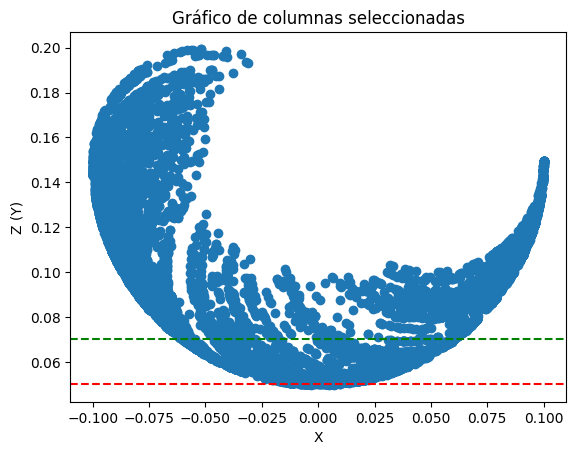

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Altura del robot en relación al piso
altura_robot = 8# centimetros
altura_robot = altura_robot/100# metros

# Alcance mázimo de la pata
returnCode = sim.simxSetJointTargetPosition(clientID, joint1, 0, sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, 0, sim.simx_opmode_oneshot)
returnCode,pos_joint1=sim.simxGetObjectPosition(clientID, joint1, -1, sim.simx_opmode_blocking)
returnCode,pos_dummy=sim.simxGetObjectPosition(clientID, dummy, -1, sim.simx_opmode_blocking)
alcance_pata = pos_joint1[2]-pos_dummy[2]

labels = ["Muslo", "Rodilla","Dummy_X", "Dummy_Y", "Dummy_Z"]
data = pd.DataFrame(data_training, columns=labels)

piso = round((pos_joint1[2]-altura_robot),4)
alcanceMax = round((pos_joint1[2]-alcance_pata),4)

plt.scatter(data["Dummy_X"], data["Dummy_Z"])
plt.axhline(y=alcanceMax, color='r', linestyle='--')
plt.axhline(y=piso, color='g', linestyle='--')
# Personalizar el gráfico
plt.xlabel('X')
plt.ylabel('Z (Y)')
plt.title('Gráfico de columnas seleccionadas')

# Mostrar el gráfico
plt.show()

In [80]:
raz_de_piso = data.loc[(data["Dummy_Z"] >= piso*0.9) & (data["Dummy_Z"] <= piso*1.1)]
max_izquierda = [round(raz_de_piso["Dummy_X"].min(), 4) , round(raz_de_piso["Dummy_Z"].loc[raz_de_piso["Dummy_X"].idxmin()], 4)]
max_derecha =   [round(raz_de_piso["Dummy_X"].max(), 4) , round(raz_de_piso["Dummy_Z"].loc[raz_de_piso["Dummy_X"].idxmax()], 4)]
print(max_izquierda, "Alcance maximo adelante")
print(max_derecha, "Alcance maximo trasero")
print(piso)

[-0.0687, 0.0769] Alcance maximo adelante
[0.0406, 0.0746] Alcance maximo trasero
0.07000000596046448


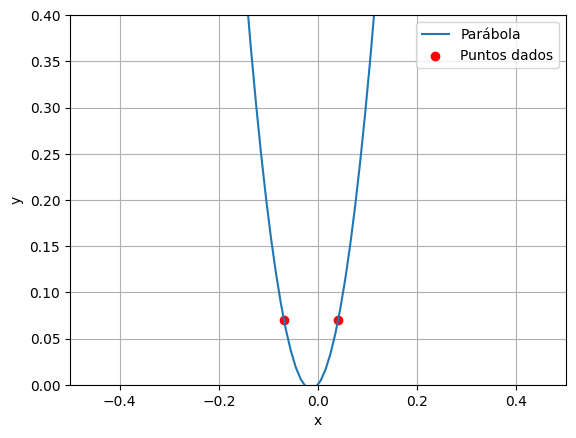

In [81]:
# Puntos dados
x1, y1 = max_izquierda[0],piso
x2, y2 = max_derecha[0],piso

def parabola_down(x, a, b, c):
    return a * x**2 + b * x + c

# Resolver el sistema de ecuaciones para encontrar los parámetros a, b, c
A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [0, 0, 1]])
B = np.array([y1, y2, 0])
a, b, c = np.linalg.solve(A, B)

# Generar puntos x en el rango deseado
x = np.linspace(-5, 5, 1000)

# Calcular los valores correspondientes de y utilizando la función de la parábola
y = parabola_down(x, a, b, c)

# Graficar la parábola y los puntos dados
plt.plot(x, y, label='Parábola')
plt.scatter([x1, x2], [y1, y2], color='red', label='Puntos dados')
# Opcional: establecer límites de los ejes para una mejor visualización
plt.xlim(-0.5, 0.5)
plt.ylim(0, 0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

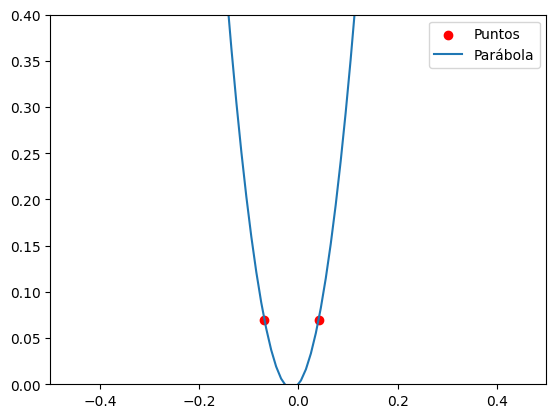

In [73]:
# Puntos dados
x1, y1 = max_izquierda[0],piso
x2, y2 = max_derecha[0],piso

# Resolver el sistema de ecuaciones para obtener los coeficientes de la parábola
A = np.array([[x1**2, x1, 1],
              [x2**2, x2, 1],
              [0**2, 0, 1]])
b = np.array([y1, y2, 0])
coeffs = np.linalg.solve(A, b)

# Generar puntos a lo largo de la parábola
x = np.linspace(-5, 5, 1000)
y = coeffs[0] * x**2 + coeffs[1] * x + coeffs[2]

# Dibujar los puntos y la parábola
plt.scatter([x1, x2], [y1, y2], color='red', label='Puntos')
plt.plot(x, y, label='Parábola')
plt.legend()

# Opcional: establecer límites de los ejes para una mejor visualización
plt.xlim(-0.5, 0.5)
plt.ylim(0, 0.4)

# Mostrar el gráfico
plt.show()

## Guardar Datos de entrenamiento en CSV

In [ ]:
# Guardar el FataFrame
data.to_csv('data.txt', sep='\t', index=False)
# Leer el DataFrame
# df = pd.read_csv('data.txt', sep='\t')

In [14]:
import pandas as pd
import tensorflow as tf
import numpy as np

SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

# Cargar los datos en un DataFrame de Pandas
data = pd.read_csv('data.txt', sep='\t')

In [15]:
data = pd.read_csv('data.txt', sep='\t')
X = data[["Dummy_X","Dummy_Z"]]
y = data[["Muslo","Rodilla"]]
muslo = data.pop('Muslo')
rodilla = data.pop('Rodilla')
tf.convert_to_tensor(X)
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X)
normalizer(X.iloc[:3])

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.26465595, -1.3803638 ],
       [-0.63483334, -0.78731   ],
       [-1.0166754 ,  0.0996276 ]], dtype=float32)>

In [16]:
def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(2)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [17]:
model = get_basic_model()
model.fit(X, y, epochs=10, batch_size=4)

Epoch 1/10
2500/2500 [==============================] - 4s 1ms/step - loss: -174.8047 - accuracy: 0.6779
Epoch 2/10
2500/2500 [==============================] - 4s 2ms/step - loss: -2350.2083 - accuracy: 0.6773
Epoch 3/10
2500/2500 [==============================] - 4s 2ms/step - loss: -8277.3877 - accuracy: 0.6764
Epoch 4/10
2500/2500 [==============================] - 4s 2ms/step - loss: -18948.7734 - accuracy: 0.6772
Epoch 5/10
2500/2500 [==============================] - 5s 2ms/step - loss: -35226.0938 - accuracy: 0.6770
Epoch 6/10
2500/2500 [==============================] - 4s 1ms/step - loss: -58224.7422 - accuracy: 0.6780
Epoch 7/10
2500/2500 [==============================] - 3s 1ms/step - loss: -89252.5078 - accuracy: 0.6771
Epoch 8/10
2500/2500 [==============================] - 3s 1ms/step - loss: -128982.8984 - accuracy: 0.6774
Epoch 9/10
2500/2500 [==============================] - 3s 1ms/step - loss: -178495.5312 - accuracy: 0.6778
Epoch 10/10
2500/2500 [================

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Extraer las características y las etiquetas del DataFrame
X = data[["Dummy_X","Dummy_Z"]]
y1 = data["Muslo"]
y2 = data["Rodilla"]

tf.convert_to_tensor(X)
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X)

x_train, x_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=42)

# Definir el modelo
model1 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2)
])

# Definir el modelo
model2 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2)
])

model1.compile(loss='mse', optimizer='adam')
model2.compile(loss='mse', optimizer='adam')
# Compilar el modelo
#model.compile(optimizer='adam',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])

# Entrenar el modelo
model1.fit(x_train, y_train, epochs=10, batch_size=2)
model2.fit(x_train2, y_train2, epochs=10, batch_size=2)

In [18]:
returnCode,target=sim.simxGetObjectHandle(clientID,'target',sim.simx_opmode_blocking)
returnCode,pos_target=sim.simxGetObjectPosition(clientID, target, -1, sim.simx_opmode_blocking)

# Ejemplo de nuevas coordenadas
nuevas_coordenadas = np.array([[pos_target[0], pos_target[2]]])

# Realizar predicciones
predicciones = model1.predict(nuevas_coordenadas)
predicciones1 = model2.predict(nuevas_coordenadas)
print("Ideal Muslo[0] = -1.13446 , Ideal Rodilla[1]= 1.13446")
print('Predicciones:', predicciones1)

returnCode = sim.simxSetJointTargetPosition(clientID, joint1, predicciones[0][0], sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, predicciones1[0][0], sim.simx_opmode_oneshot)

1/1 [==============================] - 0s 61ms/step
Ideal Muslo[0] = -1.13446 , Ideal Rodilla[1]= 1.13446
Predicciones: [[-0.01325174  0.00147966]]


In [6]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Extraer las características y las etiquetas del DataFrame
X = data[["Dummy_X","Dummy_Z"]]
y = data[["Muslo","Rodilla"]]

X = X.values
y = y.values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2)
])

model.compile(loss='mse', optimizer='adam')
# Compilar el modelo
#model.compile(optimizer='adam',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])

# Entrenar el modelo
model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
125/125 [==============================] - 1s 1ms/step - loss: 0.9518
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.7687
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.7678
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.7667
Epoch 5/10
125/125 [==============================] - 0s 2ms/step - loss: 0.7658
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.7660
Epoch 7/10
125/125 [==============================] - 0s 2ms/step - loss: 0.7645
Epoch 8/10
125/125 [==============================] - 0s 2ms/step - loss: 0.7634
Epoch 9/10
125/125 [==============================] - 0s 2ms/step - loss: 0.7633
Epoch 10/10
125/125 [==============================] - 0s 1ms/step - loss: 0.7612


In [13]:
# Paso 4: Evaluación del modelo
#puntuacion = modelo.evaluate(x_test, y_test)
#print('Puntuación de evaluación:', puntuacion)

returnCode,target=sim.simxGetObjectHandle(clientID,'target',sim.simx_opmode_blocking)
returnCode,pos_target=sim.simxGetObjectPosition(clientID, target, -1, sim.simx_opmode_blocking)

# Ejemplo de nuevas coordenadas
nuevas_coordenadas = np.array([[pos_target[0], pos_target[2]]])

# Realizar predicciones
predicciones = model.predict(nuevas_coordenadas)
print("Ideal Muslo[0] = -1.13446 , Ideal Rodilla[1]= 1.13446")
print('Predicciones:', nuevas_coordenadas)

returnCode = sim.simxSetJointTargetPosition(clientID, joint1, (round(predicciones[0][0],3)), sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, (round(predicciones[0][1],3)), sim.simx_opmode_oneshot)


1/1 [==============================] - 0s 21ms/step
Ideal Muslo[0] = -1.13446 , Ideal Rodilla[1]= 1.13446
Predicciones: [[-0.042065  0.08    ]]


In [79]:
import math
nuevas_coordenadas = np.array([[pos_target[0], pos_target[1]]])

# Función para calcular la cinemática inversa de una pierna de dos articulaciones
def calcular_cinematica_inversa(x, y, L1, L2):
    # Calcular el ángulo del muslo (hip)
    theta1 = math.atan2(y, x)

    # Calcular el ángulo de la rodilla (knee)
    r = math.sqrt(x**2 + y**2)
    theta2 = math.acos((L1**2 + L2**2 - r**2) / (2 * L1 * L2))

    return math.degrees(theta1), math.degrees(theta2)

# Valores de prueba
L1 = 0.05
L2 = 0.05
a,b = nuevas_coordenadas[0][0], nuevas_coordenadas[0][1]
# Calcular la cinemática inversa
theta1, theta2 = calcular_cinematica_inversa(a, b, L1, L2)

# Imprimir los resultados
print("Ángulo del muslo (hip):", theta1)
print("Ángulo de la rodilla (knee):", theta2)
#q1 = theta1 * np.pi/180
# Articulacion 2 (medio): -45 a 90
#q2 = theta2 * np.pi/180
returnCode = sim.simxSetJointTargetPosition(clientID, joint1, theta1+45, sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, theta2-45, sim.simx_opmode_oneshot)

Ángulo del muslo (hip): -102.04143610475782
Ángulo de la rodilla (knee): 109.76985277861687


In [49]:
returnCode,target=sim.simxGetObjectHandle(clientID,'target',sim.simx_opmode_blocking)
returnCode,pos_target=sim.simxGetObjectPosition(clientID, target, -1, sim.simx_opmode_blocking)
print(round(pos_target[0], 4),round(pos_target[1], 4),round(pos_target[2], 4))

-0.0421 -0.08 0.08


In [6]:
# muslo entre -1.5708(-90) y 0
# rodilla entre 0 y 2.0944(120)
returnCode = sim.simxSetJointTargetPosition(clientID, joint1, -0.8239341, sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, 1.0182718, sim.simx_opmode_oneshot)

In [23]:
import math

# Longitudes de los segmentos
largo_muslo = 0.06 ; largo_pierna = 0.06

# Posiciones de las articulaciones y punto a mover
posicion_motor = (0, -0.04, 0.15) ; posicion_rodilla = (0, -0.08, 0.1) ; posicion_objetivo = (-0.042, -0.08, -0.08)

# Cálculo de la cinemática inversa

# Distancias en el plano XY desde la articulación del motor al objetivo
distancia_x = posicion_objetivo[0] - posicion_motor[0]
distancia_y = posicion_objetivo[2] - posicion_motor[2]

# Distancia horizontal en el plano XY desde la articulación del motor al objetivo
d = math.sqrt(distancia_x**2 + distancia_y**2)

# Altura en el eje Z desde la articulación del motor al objetivo
h = posicion_objetivo[2] - posicion_motor[2]

# Cálculo del ángulo de la articulación del muslo
theta1 = math.atan2(h, d)
theta1_grados = math.degrees(theta1)

# Cálculo de la distancia horizontal desde la articulación del motor al objetivo en el plano XY
d2 = d - largo_pierna * math.cos(theta1)

# Cálculo de la altura desde la articulación del motor al objetivo en el plano XY
h2 = posicion_objetivo[1] - posicion_motor[1]

# Cálculo del ángulo de la articulación de la rodilla
theta2 = math.atan2(h2, d2) - theta1
theta2_grados = math.degrees(theta2)


# Imprimir los ángulos resultantes
print("Ángulo de la articulación del muslo:", theta1_grados, "grados (entre -90 y 0) --> IDEAL -65 aprox")
print("Ángulo de la articulación de la rodilla:", theta2_grados, "grados (entre 0 y 120) --> IDEAL 65 aprox")
returnCode = sim.simxSetJointTargetPosition(clientID, joint1, theta1, sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, theta2, sim.simx_opmode_oneshot)

Ángulo de la articulación del muslo: -44.530166756652314 grados (entre -90 y 0) --> IDEAL -65 aprox
Ángulo de la articulación de la rodilla: 32.70382786456999 grados (entre 0 y 120) --> IDEAL 65 aprox


In [6]:
def symTfromDH(theta,d,a,alpha):
    # theta y alpha en radianes
    # d y a en metros
    Rz = sp.Matrix([[sp.cos(theta), -sp.sin(theta), 0, 0],
                    [sp.sin(theta), sp.cos(theta), 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]
                    ])
    tz = sp.Matrix([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, d],
                    [0, 0, 0, 1],
                    ])
    ta = sp.Matrix([[1, 0, 0, a],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    ])
    Rx = sp.Matrix([[1, 0, 0, 0],
                    [0, sp.cos(alpha), -sp.sin(alpha), 0],
                    [0, sp.sin(alpha), sp.cos(alpha), 0],
                    [0, 0, 0, 1],
                    ])
    T = Rz*tz*ta*Rx
    return T

In [11]:
# Matriz de Denavit-Hartenber
#   theta   |   d   |   a   |   alpha
# ------------------------------------
#   q1      |  0.15  | 0.06  |   0
#   q2      |  0.1   | 0.06  |   0
# ------------------------------------

q1 = sp.symbols('q1')
T01 = symTfromDH(q1, 0.15, 0.06, 0)
q2 = sp.symbols('q2')
T02 = symTfromDH(q2, 0.1, 0.06, 90)
T0e = T01 * T02
T = sp.simplify(T0e)

returnCode,target=sim.simxGetObjectHandle(clientID,'target',sim.simx_opmode_blocking)
returnCode,p=sim.simxGetObjectPosition(clientID, target, -1, sim.simx_opmode_blocking)
x,y,z = p[0],p[1],p[2]
print(x,y,z)

eq1 = T[3] - x
eq2 = T[7] - y
q = sp.nsolve((eq1,eq2),(q1,q2),(1,1))

returnCode = sim.simxSetJointTargetPosition(clientID, joint1, 0.25, sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)

-0.04206499829888344 -0.07999999821186066 0.07999999821186066


In [ ]:
q1 = -75 * np.pi/180 # muslo
# Articulacion 2 (medio): -45 a 90
q2 = 76.604457 * np.pi/180 # rodilla
returnCode = sim.simxSetJointTargetPosition(clientID, joint1, q1, sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, q2, sim.simx_opmode_oneshot)